# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col, avg
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
import pandas as pd
from pyspark.ml.classification import DecisionTreeClassifier, LogisticRegression,GBTClassifier

from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler


Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20190906191918-0000
KERNEL_ID = e08dd3cb-026d-4d19-b6eb-619386796021


In [2]:

import ibmos2spark
# @hidden_cell
credentials = {
    'endpoint': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'service_id': 'iam-ServiceId-55a0526c-4a4f-45d9-adbc-e9855b49a0e1',
    'iam_service_endpoint': 'https://iam.ng.bluemix.net/oidc/token',
    'api_key': 'Co3jKyfaNPW5jySztPoJT6Nv2RH73fTQbVa-dDCyQCsS'
}

configuration_name = 'os_78c31b1028124ff3bd446c2883b01b16_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

#from pyspark.sql import SparkSession
#spark = SparkSession.builder.getOrCreate()
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

# df_data_1 = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-9ufdi2m0eneccd'))
# df_data_1.take(5)


In [3]:
# create a Spark session
spark = SparkSession.builder.appName("Sparkify").getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
df = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-9ufdi2m0eneccd'))

In [5]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

In [6]:
## check the values
df.show(5)

+-----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+------------------+------+-------------+--------------------+------+
|           artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|              song|status|           ts|           userAgent|userId|
+-----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+------------------+------+-------------+--------------------+------+
|    Martin Orford|Logged In|   Joseph|     M|           20| Morales|597.55057| free|  Corpus Christi, TX|   PUT|NextSong|1532063507000|      292|     Grand Designs|   200|1538352011000|"Mozilla/5.0 (Mac...|   293|
|John Brown's Body|Logged In|   Sawyer|     M|           74|  Larson|380.21179| free|Houston-The Woodl...|   PUT|NextSong|1538069638000|    

### Check empty values

In [7]:
def check_empty(df):
    '''
    inputs: 
            df: Spark RDD data frame
    Outputs: 
            Print the number of empty values in each column 
    Description: This method iterates each column in an RDD and counts the number of NaN values'''
    for col in df.columns:
        nan_count = df.filter((isnan(df[col])) | (df[col].isNull()) ).count()
        print("The total number of empty values for {} is {}".format(col,nan_count))
    return

In [8]:
check_empty(df)
Allrecords = df.count()

The total number of empty values for artist is 110828
The total number of empty values for auth is 0
The total number of empty values for firstName is 15700
The total number of empty values for gender is 15700
The total number of empty values for itemInSession is 0
The total number of empty values for lastName is 15700
The total number of empty values for length is 110828
The total number of empty values for level is 0
The total number of empty values for location is 15700
The total number of empty values for method is 0
The total number of empty values for page is 0
The total number of empty values for registration is 15700
The total number of empty values for sessionId is 0
The total number of empty values for song is 110828
The total number of empty values for status is 0
The total number of empty values for ts is 0
The total number of empty values for userAgent is 15700
The total number of empty values for userId is 0


Drop value with nans and preform a check after dropping those records.

In [9]:
df = df.dropna(how = "any", subset = ["userId", "sessionId"])

In [10]:
check_empty(df)

The total number of empty values for artist is 110828
The total number of empty values for auth is 0
The total number of empty values for firstName is 15700
The total number of empty values for gender is 15700
The total number of empty values for itemInSession is 0
The total number of empty values for lastName is 15700
The total number of empty values for length is 110828
The total number of empty values for level is 0
The total number of empty values for location is 15700
The total number of empty values for method is 0
The total number of empty values for page is 0
The total number of empty values for registration is 15700
The total number of empty values for sessionId is 0
The total number of empty values for song is 110828
The total number of empty values for status is 0
The total number of empty values for ts is 0
The total number of empty values for userAgent is 15700
The total number of empty values for userId is 0


In [11]:
df.describe().show()

+-------+-----------------+----------+---------+------+------------------+--------+------------------+------+----------------+------+-------+--------------------+------------------+--------------------+------------------+--------------------+--------------------+------------------+
|summary|           artist|      auth|firstName|gender|     itemInSession|lastName|            length| level|        location|method|   page|        registration|         sessionId|                song|            status|                  ts|           userAgent|            userId|
+-------+-----------------+----------+---------+------+------------------+--------+------------------+------+----------------+------+-------+--------------------+------------------+--------------------+------------------+--------------------+--------------------+------------------+
|  count|           432877|    543705|   528005|528005|            543705|  528005|            432877|543705|          528005|543705| 543705|          

In [12]:
records = df.count()
print('Total number of records in the dataset {}'.format(df.count()))
print('Total number of removed missing records {}'.format(Allrecords- records))

Total number of records in the dataset 543705
Total number of removed missing records 0


### Define Churn

Column `Churn` is the label for the model, it is defined by the `Cancellation Confirmation` events, which can happen for both paid and free users. As a bonus task.

In [13]:
##Find all possible values of page
df.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
+--------------------+
only showing top 20 rows



In [14]:
df.filter("page =='Cancellation Confirmation'").select('page').show(5)

+--------------------+
|                page|
+--------------------+
|Cancellation Conf...|
|Cancellation Conf...|
|Cancellation Conf...|
|Cancellation Conf...|
|Cancellation Conf...|
+--------------------+
only showing top 5 rows



In [15]:
function = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df_labeled = df.withColumn('churn',function('page'))
df_labeled.select("churn").dropDuplicates().show()

+-----+
|churn|
+-----+
|    1|
|    0|
+-----+



In [16]:
churned_rate = df_labeled.groupby("userId").agg({"churn": "sum"}).select(avg("sum(churn)")).collect()[0]["avg(sum(churn))"]
print("churned: {:.2f}%".format(churned_rate * 100))

churned: 22.05%


### Explore Data
After defining churn, some exploratory data analysis are performed to observe the behavior for users who stayed vs users who churned. 

In [17]:
def vis_bar(df,col):
    '''
    inputs: df: Spark dataframe that contains churn column and col
            col: String name to compare churn against
    outputs: plot bar that compares churn and col
    Description: This method takes a df and groups it by churn and col then visualize it using a barchart
    '''
    ### Extrct ID, col and churn data to pandas 
    tdf = df.groupby('userId').agg({"churn":"max",col:"max"}).toPandas()
    tdf['max(churn)'] = tdf['max(churn)'].map({1:'Churn', 0:'Not Churn'})
    tdf.columns= ['uderId',col,'churn']
    ## Visualize using seaborn
    sns.countplot(y='churn', hue=col, data=tdf,palette="Greens_d");
    return

#### Churn by gender

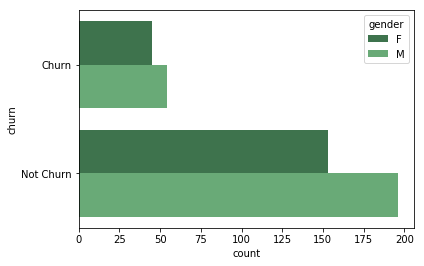

In [18]:
### Extrct ID, gender and churn data and visualize using seaborn
vis_bar(df_labeled,"gender")

#### Churn by level (Free vs Paid)

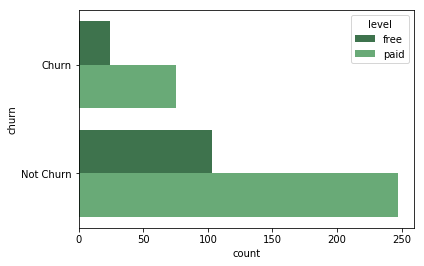

In [19]:
### Extrct ID, level and churn data and Visualize using seaborn
vis_bar(df_labeled,'level')

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [20]:
### Select data that are relevent to the problem
df_labeled.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId',
 'churn']

Features such as auth, firstName, lastName, itemInSession, location, registration, sessionId, method, song ts, status, and userAgent aren't relevent to the problem. The other values will be aggrigated and joined in a df that contains one row for each user. Binary and categorical values will be handled. 

### Total Plays

In [21]:
df_labeled.groupby("userId").agg({"artist": "count"}).show(5)

+------+-------------+
|userId|count(artist)|
+------+-------------+
|100010|           96|
|200002|          310|
|   296|          112|
|   125|           62|
|   124|         1826|
+------+-------------+
only showing top 5 rows



In [22]:
count_plays = df_labeled.groupby("userId").agg({"artist": "count"}).withColumnRenamed("count(artist)", "count_plays")
count_plays.show(5)

+------+-----------+
|userId|count_plays|
+------+-----------+
|100010|         96|
|200002|        310|
|   296|        112|
|   125|         62|
|    51|        266|
+------+-----------+
only showing top 5 rows



### Gender

Each user has a single gender value, since it is a binary catagorial Female are mapped to 1 and Males are mapped to 0.

In [23]:
map_gender = udf(lambda x: 1 if x == "F" else 0, IntegerType())
df_labeled = df_labeled.withColumn("gender", map_gender("gender"))
df_labeled.show(5)

+-----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+------------------+------+-------------+--------------------+------+-----+
|           artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|              song|status|           ts|           userAgent|userId|churn|
+-----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+------------------+------+-------------+--------------------+------+-----+
|    Martin Orford|Logged In|   Joseph|     0|           20| Morales|597.55057| free|  Corpus Christi, TX|   PUT|NextSong|1532063507000|      292|     Grand Designs|   200|1538352011000|"Mozilla/5.0 (Mac...|   293|    0|
|John Brown's Body|Logged In|   Sawyer|     0|           74|  Larson|380.21179| free|Houston-The Woodl...|   PUT|Nex

### Length

In [24]:
sum_len = df_labeled.groupby("userId").agg({"length": "sum"}).withColumnRenamed("sum(length)", "total_length")
sum_len.show(5)

+------+------------------+
|userId|      total_length|
+------+------------------+
|   296|28314.150059999996|
|100010|25870.950739999997|
|200002| 78695.82683999998|
|   125|15813.771070000003|
|    51| 66817.21162999999|
+------+------------------+
only showing top 5 rows



### Level

In [25]:
map_level = udf(lambda x: 1 if x == "paid" else 0, IntegerType())
df_labeled = df_labeled.withColumn("level", map_level("level"))
df_labeled.show(5)

+-----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+------------------+------+-------------+--------------------+------+-----+
|           artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|              song|status|           ts|           userAgent|userId|churn|
+-----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+------------------+------+-------------+--------------------+------+-----+
|    Martin Orford|Logged In|   Joseph|     0|           20| Morales|597.55057|    0|  Corpus Christi, TX|   PUT|NextSong|1532063507000|      292|     Grand Designs|   200|1538352011000|"Mozilla/5.0 (Mac...|   293|    0|
|John Brown's Body|Logged In|   Sawyer|     0|           74|  Larson|380.21179|    0|Houston-The Woodl...|   PUT|Nex

### Interaction

In [26]:
df.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
+--------------------+
only showing top 20 rows



In [27]:
map_up = udf(lambda x: 1 if x == "Thumbs Up" else 0, IntegerType())
map_down = udf(lambda x: 1 if x == "Thumbs Down" else 0, IntegerType())

df_labeled = df_labeled.withColumn("thumbs_up", map_up("page")).withColumn("thumbs_down", map_level("page"))
df_labeled.show(5)

+-----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+------------------+------+-------------+--------------------+------+-----+---------+-----------+
|           artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|              song|status|           ts|           userAgent|userId|churn|thumbs_up|thumbs_down|
+-----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+------------------+------+-------------+--------------------+------+-----+---------+-----------+
|    Martin Orford|Logged In|   Joseph|     0|           20| Morales|597.55057|    0|  Corpus Christi, TX|   PUT|NextSong|1532063507000|      292|     Grand Designs|   200|1538352011000|"Mozilla/5.0 (Mac...|   293|    0|        0|          0|
|John Brown's Body|Logged In

### Putting it all together

In [28]:
df_features = df_labeled.groupby('userId').agg({"churn":"max","gender":"max","level":"max","thumbs_up":"sum","thumbs_down":"sum"}).withColumnRenamed("sum(length)", "length").withColumnRenamed("sum(thumbs_up)", "thumbs_up").withColumnRenamed("max(churn)", "label").withColumnRenamed("sum(thumbs_down)", "thumbs_down").withColumnRenamed("max(gender)", "gender").withColumnRenamed("max(level)", "level")

df_features.show(5)

+------+---------+-----+-----------+------+-----+
|userId|thumbs_up|label|thumbs_down|gender|level|
+------+---------+-----+-----------+------+-----+
|   296|        8|    1|          0|     1|    1|
|100010|        4|    1|          0|     1|    0|
|200002|       15|    1|          0|     0|    1|
|   125|        3|    0|          0|     0|    0|
|    51|       16|    1|          0|     0|    1|
+------+---------+-----+-----------+------+-----+
only showing top 5 rows



In [29]:
df_features = df_features.join(count_plays, ['userId']).join(sum_len, ['userId'])
df_features.show(5)

+------+---------+-----+-----------+------+-----+-----------+------------------+
|userId|thumbs_up|label|thumbs_down|gender|level|count_plays|      total_length|
+------+---------+-----+-----------+------+-----+-----------+------------------+
|100010|        4|    1|          0|     1|    0|         96|25870.950739999997|
|200002|       15|    1|          0|     0|    1|        310| 78695.82683999998|
|   296|        8|    1|          0|     1|    1|        112|28314.150059999996|
|   125|        3|    0|          0|     0|    0|         62|15813.771070000003|
|   124|      102|    1|          0|     1|    1|       1826|      456664.04058|
+------+---------+-----+-----------+------+-----+-----------+------------------+
only showing top 5 rows



### Transform Features

In [30]:
#create features column
df_features = df_features.fillna(0)
assembler = VectorAssembler(
    inputCols= ['thumbs_up','thumbs_down', 'gender','level','count_plays',  'total_length'],
    outputCol="features")
vec_features = assembler.transform(df_features)
vec_features.show(5)

+------+---------+-----+-----------+------+-----+-----------+------------------+--------------------+
|userId|thumbs_up|label|thumbs_down|gender|level|count_plays|      total_length|            features|
+------+---------+-----+-----------+------+-----+-----------+------------------+--------------------+
|100010|        4|    1|          0|     1|    0|         96|25870.950739999997|[4.0,0.0,1.0,0.0,...|
|200002|       15|    1|          0|     0|    1|        310| 78695.82683999998|[15.0,0.0,0.0,1.0...|
|   296|        8|    1|          0|     1|    1|        112|28314.150059999996|[8.0,0.0,1.0,1.0,...|
|   125|        3|    0|          0|     0|    0|         62|15813.771070000003|[3.0,0.0,0.0,0.0,...|
|   124|      102|    1|          0|     1|    1|       1826|      456664.04058|[102.0,0.0,1.0,1....|
+------+---------+-----+-----------+------+-----+-----------+------------------+--------------------+
only showing top 5 rows



/opt/ibm/conda/miniconda36/lib/python3.6/site-packages/pandas/plotting/_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
/opt/ibm/conda/miniconda36/lib/python3.6/site-packages/pandas/plotting/_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
/opt/ibm/conda/miniconda36/lib/python3.6/site-packages/pandas/plotting/_misc.py:109: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  ax.set_ylim(boundaries_list[i])
/opt/ibm/conda/miniconda36/lib/python3.6/site-packages/pandas/plotting/_misc.py:109: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  ax.set_ylim(boun

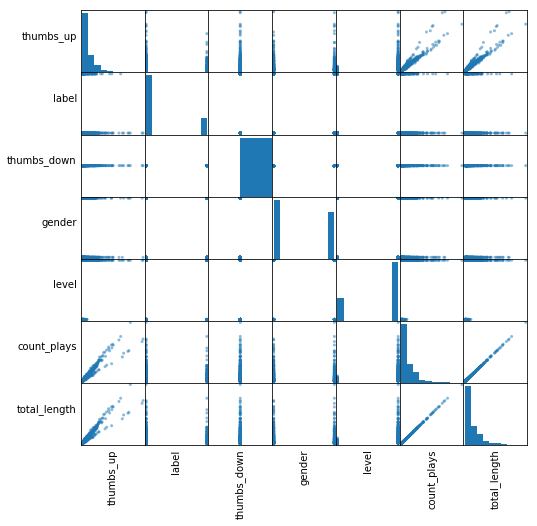

In [31]:
numeric_data = df_features.drop('userId').toPandas()
axs = pd.plotting.scatter_matrix(numeric_data, figsize=(8, 8));
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [32]:
## Split data into train test set
train, test = vec_features.randomSplit([0.8, 0.2], seed=12345)
#train_y = train.select("label")
#train_x =train.drop("userId").drop("label")
train.show(5)
test.show(5)
#test_y = test.select("churn")
#test_x =test.drop("userId").drop("label")
train.persist()
test.persist()

+------+---------+-----+-----------+------+-----+-----------+------------------+--------------------+
|userId|thumbs_up|label|thumbs_down|gender|level|count_plays|      total_length|            features|
+------+---------+-----+-----------+------+-----+-----------+------------------+--------------------+
|100010|        4|    1|          0|     1|    0|         96|25870.950739999997|[4.0,0.0,1.0,0.0,...|
|200002|       15|    1|          0|     0|    1|        310| 78695.82683999998|[15.0,0.0,0.0,1.0...|
|   296|        8|    1|          0|     1|    1|        112|28314.150059999996|[8.0,0.0,1.0,1.0,...|
|   125|        3|    0|          0|     0|    0|         62|15813.771070000003|[3.0,0.0,0.0,0.0,...|
|   124|      102|    1|          0|     1|    1|       1826|      456664.04058|[102.0,0.0,1.0,1....|
+------+---------+-----+-----------+------+-----+-----------+------------------+--------------------+
only showing top 5 rows

+------+---------+-----+-----------+------+-----+--------

DataFrame[userId: string, thumbs_up: bigint, label: int, thumbs_down: bigint, gender: int, level: int, count_plays: bigint, total_length: double, features: vector]

In [45]:
def create_model(model, train,test):
    '''
    inputs: model: the model to be trained
            train: train dataframe
            test: test datafram
        outputs: model: return trained model
        Description: this methods trains and tests the model and prints the F1 and accuracy scores'''
    model=model.fit(train)
    predict_train=model.transform(train)
    predict_test=model.transform(test)
    predict_test.show(10)
    evaluator = MulticlassClassificationEvaluator()#.setLabelCol("label").setRawPredictionCol("prediction")
    result = evaluator.evaluate(predict_test, {evaluator.metricName: "f1"})
    print("F1 score: {}".format(result))
    result = evaluator.evaluate(predict_test, {evaluator.metricName: "accuracy"})
    print("Accuracy score: {}".format(result))
    return model


## Logistic Regression

In [78]:
# Fit model
lr = LogisticRegression(maxIter=1,regParam=0.02, elasticNetParam=0.08, featuresCol = 'features', labelCol = 'label')
lr =create_model(lr, train,test)

+------+---------+-----+-----------+------+-----+-----------+------------------+--------------------+--------------------+--------------------+----------+
|userId|thumbs_up|label|thumbs_down|gender|level|count_plays|      total_length|            features|       rawPrediction|         probability|prediction|
+------+---------+-----+-----------+------+-----+-----------+------------------+--------------------+--------------------+--------------------+----------+
|   169|        6|    0|          0|     0|    0|        112|28033.438189999993|[6.0,0.0,0.0,0.0,...|[1.20606904478794...|[0.76960267289389...|       0.0|
|   205|       50|    0|          0|     1|    1|       1048|263650.81615999993|[50.0,0.0,1.0,1.0...|[1.11229807885159...|[0.75255729608978...|       0.0|
|   234|       91|    1|          0|     0|    1|       1674|418121.37650999933|[91.0,0.0,0.0,1.0...|[1.17262657451638...|[0.76361945322770...|       0.0|
|   282|      133|    0|          0|     0|    1|       2629| 661221.6

## Decision Tree Classifier

In [71]:
dt = DecisionTreeClassifier( featuresCol = 'features', labelCol = 'label')
dt = create_model(dt, train,test)

+------+---------+-----+-----------+------+-----+-----------+------------------+--------------------+-------------+--------------------+----------+
|userId|thumbs_up|label|thumbs_down|gender|level|count_plays|      total_length|            features|rawPrediction|         probability|prediction|
+------+---------+-----+-----------+------+-----+-----------+------------------+--------------------+-------------+--------------------+----------+
|   169|        6|    0|          0|     0|    0|        112|28033.438189999993|[6.0,0.0,0.0,0.0,...|   [17.0,7.0]|[0.70833333333333...|       0.0|
|   205|       50|    0|          0|     1|    1|       1048|263650.81615999993|[50.0,0.0,1.0,1.0...|   [20.0,6.0]|[0.76923076923076...|       0.0|
|   234|       91|    1|          0|     0|    1|       1674|418121.37650999933|[91.0,0.0,0.0,1.0...|   [34.0,2.0]|[0.94444444444444...|       0.0|
|   282|      133|    0|          0|     0|    1|       2629| 661221.6519699993|[133.0,0.0,0.0,1....|   [34.0,2.

## Gradient-Boosted Tree Classifier

In [56]:
db = GBTClassifier(maxIter=10, featuresCol = 'features', labelCol = 'label')
db = create_model(db, train,test)

+------+---------+-----+-----------+------+-----+-----------+------------------+--------------------+--------------------+--------------------+----------+
|userId|thumbs_up|label|thumbs_down|gender|level|count_plays|      total_length|            features|       rawPrediction|         probability|prediction|
+------+---------+-----+-----------+------+-----+-----------+------------------+--------------------+--------------------+--------------------+----------+
|   169|        6|    0|          0|     0|    0|        112|28033.438189999993|[6.0,0.0,0.0,0.0,...|[0.75228887786278...|[0.81825623989465...|       0.0|
|   205|       50|    0|          0|     1|    1|       1048|263650.81615999993|[50.0,0.0,1.0,1.0...|[0.59023968021314...|[0.76503398309722...|       0.0|
|   234|       91|    1|          0|     0|    1|       1674|418121.37650999933|[91.0,0.0,0.0,1.0...|[1.07582918718726...|[0.89582364404177...|       0.0|
|   282|      133|    0|          0|     0|    1|       2629| 661221.6

### Improvements

Deciding on the Gradient-Boosted Tree Classifier, we can improve the performance of the model by optimizing its hyperparameters. We use grid search to fine tune the model parameters and then validate the model by using cross validation. We mainly tuned two tree specific parameters: max depth and max iterations.

In [65]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

gbt = DecisionTreeClassifier(maxDepth = 3, featuresCol = 'features', labelCol = 'label')

# build paramGrid
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth,[5, 6]) \
    .addGrid(gbt.maxBins, [10,12]) \
    .build()

# set evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

crossval_gbt = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=f1_evaluator,
                          numFolds=3)

cv_gbt = crossval_gbt.fit(train)
#cvModel_gbt.

In [68]:
#predict_test = cvModel_gbt.transform(test)
predict_test = cv_gbt.transform(test)

In [69]:
evaluator = MulticlassClassificationEvaluator()#.setLabelCol("label").setRawPredictionCol("prediction")
result = evaluator.evaluate(predict_test, {evaluator.metricName: "f1"})
print("F1 score: {}".format(result))
result = evaluator.evaluate(predict_test, {evaluator.metricName: "accuracy"})
print("Accuracy score: {}".format(result))

F1 score: 0.7308914624293025
Accuracy score: 0.7446808510638298


### Feature importance

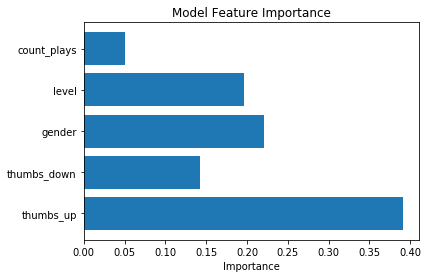

In [88]:
import numpy as np
feat_imp = cv_gbt.bestModel.featureImportances.values
cols =['thumbs_up','thumbs_down', 'gender','level','count_plays']
y_pos = np.arange(len(cols))
 
plt.barh(y_pos, feat_imp, align='center')
plt.yticks(y_pos, cols)
plt.xlabel('Importance')
plt.title('Model Feature Importance');



## Next steps and improvment
Despite the model's great results there is a room for improvment: 
1- Work with a bigger dataset that has more events.
2- Feature engineering by understanding how other events in page could correlate with the churn rate.